# Notebook 2: Modelado con Scikit-learn

## Objetivo

Este notebook se enfoca en construir, entrenar y evaluar un modelo de clasificación utilizando el ecosistema de Scikit-learn. Las tareas específicas son:

1.  **Cargar** el conjunto de datos limpio generado en el notebook anterior.
2.  **Construir un pipeline de preprocesamiento** para manejar la imputación, codificación y escalado de características.
3.  **Entrenar un `RandomForestClassifier`** y optimizar sus hiperparámetros usando `GridSearchCV`.
4.  **Evaluar** el rendimiento del mejor modelo en el conjunto de prueba.
5.  **Guardar** el modelo entrenado y sus métricas de rendimiento para su uso posterior.

-   **Entrada:** `../data/processed/loans_cleaned.parquet`
-   **Salidas:**
    -   `../models/sklearn_random_forest.joblib` (El pipeline del modelo entrenado)
    -   `../results/sklearn_metrics.json` (Las métricas de evaluación y el tiempo de entrenamiento)

### 1. Importación de Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import json
import os

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# Configuraciones de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### 2. Definición de Rutas y Carga de Datos

In [3]:
# Definir las rutas relativas
PROCESSED_DATA_PATH = '../data/processed/loans_cleaned.parquet'
MODEL_PATH = '../models/sklearn_random_forest.joblib'
RESULTS_PATH = '../results/sklearn_metrics.json'
MODELS_DIR = '../models'
RESULTS_DIR = '../results'

# Crear los directorios de salida si no existen
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

In [9]:
# Cargar el dataset procesado
df = pd.read_parquet(PROCESSED_DATA_PATH)

print(f"Dataset cargado exitosamente desde '{PROCESSED_DATA_PATH}'")
print(f"Dimensiones del dataset: {df.shape}")
df.head()

Dataset cargado exitosamente desde 'data/processed/loans_cleaned.parquet'
Dimensiones del dataset: (1345310, 10)


,loan_amnt,int_rate,fico_range_high,emp_length,annual_inc,purpose,home_ownership,dti,addr_state,default
0,3600.0,13.99,679.0,10.0,55000.0,debt_consolidation,MORTGAGE,5.91,PA,0
1,24700.0,11.99,719.0,10.0,65000.0,small_business,MORTGAGE,16.06,SD,0
2,20000.0,10.78,699.0,10.0,63000.0,home_improvement,MORTGAGE,10.78,IL,0
3,10400.0,22.45,699.0,3.0,104433.0,major_purchase,MORTGAGE,25.37,PA,0
4,11950.0,13.44,694.0,4.0,34000.0,debt_consolidation,RENT,10.20,GA,0


### 3. Preparación de Datos para el Modelo

Dividimos los datos en características (`X`) y variable objetivo (`y`), y luego en conjuntos de entrenamiento y prueba.

In [10]:
# Separar características y variable objetivo
X = df.drop('default', axis=1)
y = df['default']

# Dividir en conjuntos de entrenamiento (80%) y prueba (20%)
# Usamos stratify=y para mantener la proporción de clases en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Dimensiones de los conjuntos de datos:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Dimensiones de los conjuntos de datos:
X_train: (1076248, 9), y_train: (1076248,)
X_test: (269062, 9), y_test: (269062,)


### 4. Construcción del Pipeline de Preprocesamiento y Modelado

Creamos un pipeline que automatiza todos los pasos: imputación de valores faltantes, codificación de variables categóricas, escalado de variables numéricas y el clasificador final.

In [11]:
# Identificar columnas numéricas y categóricas
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

print("Columnas Numéricas:", numerical_features)
print("Columnas Categóricas:", categorical_features)

# Crear pipeline para transformaciones numéricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputar con la mediana
    ('scaler', StandardScaler())                    # Escalar características
])

# Crear pipeline para transformaciones categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Imputar con el valor más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Codificación One-Hot
])

# Combinar los transformadores en un único preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Mantiene columnas no especificadas (si las hubiera)
)

# Crear el pipeline final que incluye el preprocesador y el clasificador
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

print("\nPipeline de Scikit-learn creado exitosamente.")

Columnas Numéricas: ['loan_amnt', 'int_rate', 'fico_range_high', 'emp_length', 'annual_inc', 'dti']
Columnas Categóricas: ['purpose', 'home_ownership', 'addr_state']

Pipeline de Scikit-learn creado exitosamente.


### 5. Entrenamiento y Ajuste de Hiperparámetros con GridSearchCV

Buscamos la mejor combinación de hiperparámetros para nuestro `RandomForestClassifier` y medimos el tiempo que toma este proceso.

In [12]:
# Definir el grid de hiperparámetros a explorar
param_grid = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__max_depth': [5, 10, 15]
}

# Configurar GridSearchCV
# Usamos 3-fold Cross-Validation y optimizamos para ROC AUC
grid_search = GridSearchCV(
    model_pipeline, 
    param_grid, 
    cv=3,
    scoring='roc_auc', 
    verbose=2
)

# Medir el tiempo de entrenamiento
print("Iniciando GridSearchCV para Scikit-learn...")
start_time_sklearn = time.time()
grid_search.fit(X_train, y_train)
end_time_sklearn = time.time()

sklearn_training_time = end_time_sklearn - start_time_sklearn

print(f"\nGridSearchCV completado en {sklearn_training_time:.2f} segundos.")
print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")
print(f"Mejor puntuación ROC AUC (en validación cruzada): {grid_search.best_score_:.4f}")

Iniciando GridSearchCV para Scikit-learn...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END classifier__max_depth=5, classifier__n_estimators=10; total time=   4.5s
[CV] END classifier__max_depth=5, classifier__n_estimators=10; total time=   4.4s
[CV] END classifier__max_depth=5, classifier__n_estimators=10; total time=   4.1s
[CV] END classifier__max_depth=5, classifier__n_estimators=50; total time=  13.3s
[CV] END classifier__max_depth=5, classifier__n_estimators=50; total time=  14.2s
[CV] END classifier__max_depth=5, classifier__n_estimators=50; total time=  14.7s
[CV] END classifier__max_depth=5, classifier__n_estimators=100; total time=  26.2s
[CV] END classifier__max_depth=5, classifier__n_estimators=100; total time=  22.5s
[CV] END classifier__max_depth=5, classifier__n_estimators=100; total time=  21.4s
[CV] END classifier__max_depth=10, classifier__n_estimators=10; total time=   8.1s
[CV] END classifier__max_depth=10, classifier__n_estimators=10; total ti

### 6. Evaluación del Mejor Modelo

Usamos el mejor modelo encontrado por `GridSearchCV` para hacer predicciones en el conjunto de prueba y calcular las métricas de rendimiento.

In [13]:
# Obtener el mejor estimador (pipeline completo)
best_model_sklearn = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred_sklearn = best_model_sklearn.predict(X_test)
y_proba_sklearn = best_model_sklearn.predict_proba(X_test)[:, 1]

# Calcular las métricas de evaluación
sklearn_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_sklearn),
    'Precision': precision_score(y_test, y_pred_sklearn),
    'Recall': recall_score(y_test, y_pred_sklearn),
    'F1-score': f1_score(y_test, y_pred_sklearn),
    'ROC AUC': roc_auc_score(y_test, y_proba_sklearn)
}

print("Métricas de Evaluación en el Conjunto de Prueba (Scikit-learn):")
for metric, value in sklearn_metrics.items():
    print(f"- {metric}: {value:.4f}")

Métricas de Evaluación en el Conjunto de Prueba (Scikit-learn):
- Accuracy: 0.8006
- Precision: 0.6496
- Recall: 0.0028
- F1-score: 0.0056
- ROC AUC: 0.7028


#### Matriz de Confusión
Visualizamos la matriz de confusión para entender mejor el tipo de errores que comete el modelo.

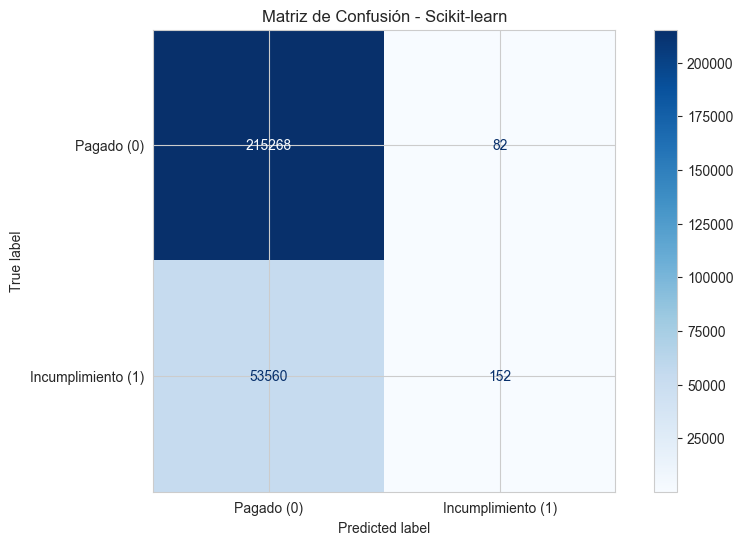

In [14]:
cm = confusion_matrix(y_test, y_pred_sklearn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pagado (0)', 'Incumplimiento (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Scikit-learn')
plt.show()

### 7. Guardado de Artefactos (Modelo y Resultados)

Guardamos el pipeline del modelo entrenado y un archivo JSON con las métricas y el tiempo de entrenamiento para su uso en los notebooks de interpretabilidad y comparación.

In [15]:
# Guardar el pipeline del modelo
joblib.dump(best_model_sklearn, MODEL_PATH)
print(f"Modelo de Scikit-learn guardado en: '{MODEL_PATH}'")

# Crear un diccionario con todos los resultados
final_results = {
    'best_params': grid_search.best_params_,
    'metrics': sklearn_metrics,
    'training_time_seconds': sklearn_training_time
}

# Guardar los resultados en un archivo JSON
with open(RESULTS_PATH, 'w') as f:
    json.dump(final_results, f, indent=4)

print(f"Resultados de Scikit-learn guardados en: '{RESULTS_PATH}'")

Modelo de Scikit-learn guardado en: 'models/sklearn_random_forest.joblib'
Resultados de Scikit-learn guardados en: 'results/sklearn_metrics.json'


---
### Fin del Notebook 2

Hemos entrenado y evaluado con éxito un modelo RandomForest utilizando Scikit-learn. Los artefactos resultantes están listos para el siguiente paso, que será realizar el mismo proceso con PySpark.
---